# Preliminary

In [22]:
%matplotlib

import sys
sys.path.append('..\Instrument Driver')
sys.path.append('..\Helper') 

import os
import matplotlib.pyplot as plt   
import numpy as np
import json
import visa
import time
from scipy import optimize
import logging
from plotter import QuadPlotter  
import re

logging.basicConfig(level=logging.INFO) # set logging level to be INFO.

def create_log_file(params):
    """  Create a log file in json using parameters"""
    
    full_file_name = get_full_file_name(params)
    params.full_file_path = os.path.join(params.base_path,full_file_name)    
    full_log_file_path = params.full_file_path.replace('.dat','.json')
    
    with open(full_log_file_path, 'w') as f:
        json.dump(vars(params),f,indent=4, sort_keys=True)
    logging.info(f'{params.full_file_path} created')
 
def get_full_file_name(params):
    """ Create a full file name with file extension 'dat'.
        File name structure: ID number_Sample ID_Exp name.dat. 
        ex) 1_NbTi_VI.dat
    """
    full_file_name = get_file_ID_number(params) + '_' + params.sample_ID + '_' + params.exp_name + '.dat'
    
    return full_file_name

def get_file_ID_number(params):
    """ Find ID number used to create a full file name. 
        Under base path, search for all ID numbers of files and decide
        what ID to be used next
        Args: 
            params: instance of Params class
        Return: next ID number in str to be used
        """
    ID_numbers = []
    for (root,dirs,files) in os.walk(params.base_path, topdown=True):
        
        for file in files:
            matchobj = re.match(r'^\d+', file)
            if matchobj:
                ID_numbers.append(int(matchobj.group()))    
    if ID_numbers:
        return str(np.max(ID_numbers) + 1)
    else:
        return str(1)

class Parameters:
    """ Placehoder for parameters """
    def __init__(self, base_path=None, sample_ID=None):
        self.base_path = base_path
        self.sample_ID = sample_ID

def PNA_configure(**kwargs):
    for k,v in kwargs:
        try:
            setattr(self, k, v)
        except AttributeError:
            print(f'method named {k} does not exist. Check instrument driver')
            continue
 
def linear_to_dB(S21_linear):
    dB = 20 * np.log10(np.absolute(S21_linear))
    return dB

def find_res_freq(freq, S21):
    '''
    Fit with lorentzian 
    Args:
        freqs: numpy array of frequencies
        S21: numpy arrary of S21 in complex number
    Return:  resonance frequency
    '''
    res_freq = 
    
    return res_freq


Using matplotlib backend: Qt5Agg


# Set up instrument and some parameters in common

In [14]:
import SIM, LSCI332S, HittiteHMC, SynthHD, KeysightP9372A

pna = KeysightP9372A.KeysightP9372A('PXI10::0-0.0::INSTR')
pna.connect()
# flux = SIM.SIM(18, channel = 1)

#spec = HittiteHMC.HittiteHMC('USB',4)
#lsci = LSCI332S.LSCI332S(2)
#pump = SynthHD.SynthHD(18)

base_path = r'Z:\User\Jaseung\temp\temp'
sample_ID = 'Test'

# Cav vs Freq, 1D, single scan

In [23]:
############################ Set parameters ################################################
params = Parameters(base_path, sample_ID)

# PNA
params.freq_start, params.freq_end = 1e6, 9e9
params.power = -30
params.num_points = 801
params.avg = 2
params.IF = 1e3

# flux params
# params.flux_init = 0
# params.flux_final = 0

# file params
params.exp_name = 'Cav'

###########################################################3#################################

create_log_file(params)
quad_plotter = QuadPlotter()
quad_plotter.initialize(plot_dim=1
                        , xlabel='Frequency (Hz)'
                        , title=get_full_file_name(params))

# initialize instruments
pna.setupMeas('S21')
pna.setSweepType('linear')
pna.setFreqStartEnd(params.freq_start, params.freq_end)
pna.avgCount(params.avg)
pna.numPoints(params.num_points)
pna.setIF(params.IF)
pna.setPwr(params.power)

# flux.setVoltage(parama.flux_init)

# sweep
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
data = S21

quad_plotter.update(xdata=freq
                    , amp=np.abs(data), phase=np.angle(data, deg=True), real=data.real, imag=data.imag)

with open(params.full_file_path,'wb') as f:
    np.savetxt(f, data, delimiter=',',fmt='%.9e')

# Post measurement
# params.flux.setVolage(parama.flux.flux_final)

fig_full_file_path = params.full_file_path.replace('dat','png')
quad_plotter.fig.savefig(fig_full_file_path)

logging.info('Measurement complete!!!')

INFO:root:Z:\User\Jaseung\temp\temp\19_Test_Cav.dat created
INFO:root:Measurement complete!!!


# Cav vs Power, 2D

INFO:root:Z:\User\Jaseung\temp\temp\11_Test_Cav_vs_P_2D.dat created
INFO:root:Measurement complete!!!


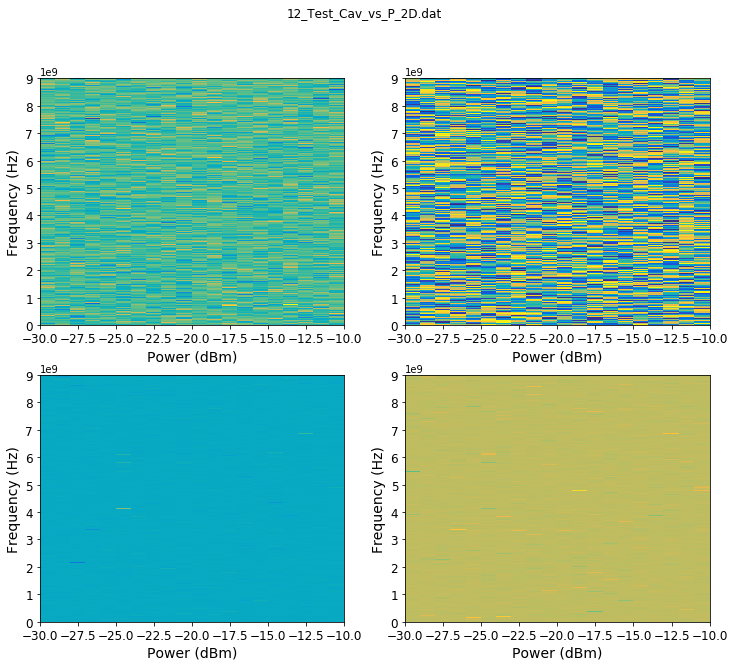

In [3]:
############################ Set parameters ################################################
params = Parameters(base_path, sample_ID)

# PNA
params.freq_start, params.freq_end = 1e6, 9e9
params.num_points = 801
params.avg = 2
params.IF_start = 100e3
params.IF_end = 100e3

# flux params
# params.flux_init = 0
# params.flux_final = 0

# sweep params
params.power_start = -30
params.power_end = -10
params.power_step = 1

# file params
params.exp_name = 'Cav_vs_P_2D'
###########################################################3#################################

create_log_file(params)
quad_plotter = QuadPlotter()
quad_plotter.initialize(plot_dim=2
                        , xlabel='Power (dBm)'
                        , ylabel='Frequency (Hz)'
                        , title=get_full_file_name(params))

# initialize instruments
pna.setupMeas('S21')
pna.setSweepType('linear')
pna.setFreqStartEnd(params.freq_start, params.freq_end)
pna.avgCount(params.avg)
pna.numPoints(params.num_points)

# params.flux.setVoltage(parama.flux.flux_init)

# sweep
powers = np.arange(params.power_start, params.power_end + params.power_step, params.power_step)
IFBandwiths = np.linspace(params.IF_start, params.IF_end, len(powers)) # IFbandwidth scales up linearly

data = None
power_list = []
for pwr, IF in zip(powers, IFBandwiths):
    # configure
    pna.setIF(IF)
    pna.setPwr(pwr)
    pna.avgClear()
    
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale

    if data is not None:
        data = np.column_stack((data, S21))
    else:
        data = np.reshape(S21,(len(S21),1))
    
    # plot update
    power_list.append(pwr)
    quad_plotter.update(x_axis=power_list, y_axis=freq
                        , amp=linear_to_dB(np.abs(data)), phase=np.angle(data, deg=True), real=data.real, imag=data.imag)

    # save data in each iteration
    with open(params.full_file_path,'wb') as f:
        np.savetxt(f, data, delimiter=',',fmt='%.9e')

# Post measurement
# params.flux.setVolage(parama.flux.flux_final)

fig_full_file_path = params.full_file_path.replace('dat','png')
quad_plotter.fig.savefig(fig_full_file_path)

logging.info('Measurement complete!!!')


In [ ]:
%%time
###########################################################################
# set up parameters
def starkvsflux( flux, freqstart, freqend):
    startFreq, endFreq = 5.17e9, 5.19e9
    power = -73
    numPoints, IFbandwidth, avg = 800, 500, 50
    startVolt, endVolt, stepVolt = -1.5, 1.5, 0.5

    sweepVoltSrc = 1 # 1: Vchip, 2: Vglb
    #Vglb_init = 0
    #Vglb_end = 0  
    #Vchip_init =0
    #Vchip_end = 0

    sampleID = 'Q1'
    suffix = ''
    
    save_path = r'Z:\PHY-PRL-Labshare\User\Andrew\Flip-Chip_measurements\JN90_MCM16'
    #save_path = r'Z:\User\Andrew\Flip-Chip_measurements\HYP2'
    #save_path = r'C:\Users\Lab User\Desktop\Plaquette\RF_SQUID\0602'
    #save_path = r'Z:\User\JJ\SFQ3\HYP1'
    #save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W14\B8\ADR2'
    #save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF'
    #save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\DD5\BF'
    #save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\A8\ADR2'
    #save_path = r'Z:\User\Caleb\ch061'
    #save_path = r'C:\Users\Lab User\Desktop\Flux'
    commentStr =''
    ############################################################################

    # dictionary for parameters to be saved in json file. Solely for log.
    xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
    yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
    para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
                 , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
                 , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
                 , ('avg',avg), ('comment', commentStr)])

    # file setup
    if fridgeType=='ADR2':
        
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0    
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
    baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
    dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                             os.path.join(save_path, baseFileName + '_phase.dat'))
    logFileName =  os.path.join(save_path, baseFileName + '.json')
    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)

    # plot setup
    plotobj= myplots_py3.plot2D(ylabel = 'Frequency (Hz)', xlabel='Volt (V)', title = baseFileName)

    # preconfigure instrument
    pna.setupMeas()
    pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(avg)
    pna.numPoints(numPoints)
    pna.setIF(IFbandwidth)
    pna.pwrOn()

    sim_glb.setVoltage(Vglb_init)
    #sim_chip.setVoltage(Vchip_init)
    sim_glb.setVoltage(startVolt)
    #sim_chip.setVoltage(startVolt)
    #sim_p.setVoltage(startVolt)

    time.sleep(2)

    # data initialization
    S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

    ################ sweep start ################
    for volt in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
        clear_output()
        print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt))

        # configure
        if sweepVoltSrc==1:
            sim_chip.setVoltage(volt)
    #         pass
        elif sweepVoltSrc==2:
            sim_p.setVoltage(volt)

        #time.sleep(0.5)
        pna.avgClear()

        # fetch data from PNA
        freq, S21 = pna.getData(cplx=True) # S21 in linear scale

        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
            S21_mag_log_2D = S21_mag_log
            #S21_mag_log_2D = S21_real
            S21_mag_log_2D.shape = (S21_mag_log.size, 1)
            S21_phase_2D = S21_phase
            #S21_phase_2D = S21_imag
            S21_phase_2D.shape = (S21_phase.size, 1)
        else:
            S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
            S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
            #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
            #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))

        # plot update
        extent = [startVolt, volt, startFreq, endFreq]
        #plotobj.update(S21_mag_log_2D, extent)

        # save data in each iteration
    #     f_mag = open(dataFileName_mag, 'w') 
    #     f_phase = open(dataFileName_phase, 'w') 
    #     np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    #     np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    #     f_mag.close()
    #     f_phase.close()

    ############## sweep end #########################    
    # save at the end
    f_mag = open(dataFileName_mag, 'wb') 
    f_phase = open(dataFileName_phase, 'wb') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()


    # Post measurement   
    del S21_mag_log_2D, S21_phase_2D
    pna.pwrOff()
    sim_p.setVoltage(Vglb_end)
    sim_chip.setVoltage(Vchip_end)
    plotobj.update(S21_mag_log_2D, extent)
    plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
    print('Measurement done!!!')

# Cav vs Flux, 2D 

In [ ]:
############################ Set parameters ################################################
params = Parameters(base_path, sample_ID)

# PNA
params.freq_start, params.freq_end = 1e6, 9e9
params.num_points = 801
params.avg = 2
params.IF = 1e3

# flux params
params.flux_start = 0
params.flux_end = 0
params.flux_step = 0

# sweep params
params.power_start = -30
params.power_end = -10
params.power_step = 1

# file params
params.exp_name = 'Cav_vs_flux_2D'
###########################################################3#################################

create_log_file(params)
quad_plotter = QuadPlotter()
quad_plotter.initialize(plot_dim=2
                        , xlabel='Power (dBm)'
                        , ylabel='Frequency (Hz)'
                        , title=get_full_file_name(params))

# initialize instruments
pna.setupMeas('S21')
pna.setSweepType('linear')
pna.setFreqStartEnd(params.freq_start, params.freq_end)
pna.avgCount(params.avg)
pna.numPoints(params.num_points)
pna.setPwr(params.power)
pna.setIF(params.IF)

# params.flux.setVoltage(parama.flux.flux_init)

# sweep
flux_sweep = np.arange(params.flux_start, params.flux_end + params.flux_step, params.flux_step)

data = None
flux_list = []
for pwr, IF in flux_sweep
    # configure 
    pna.avgClear()
    
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale

    if data is not None:
        data = np.column_stack((data, S21))
    else:
        data = np.reshape(S21,(len(S21),1))
    
    # plot update
    flux_list.append(pwr)
    quad_plotter.update(x_axis=flux_list, y_axis=freq
                        , amp=linear_to_dB(np.abs(data)), phase=np.angle(data, deg=True), real=data.real, imag=data.imag)

    # save data in each iteration
    with open(params.full_file_path,'wb') as f:
        np.savetxt(f, data, delimiter=',',fmt='%.9e')

# Post measurement
# params.flux.setVolage(parama.flux.flux_final)

fig_full_file_path = params.full_file_path.replace('dat','png')
quad_plotter.fig.savefig(fig_full_file_path)

logging.info('Measurement complete!!!')


# spec, 1D

In [ ]:
############################ Set parameters ################################################
params = Parameters(base_path, sample_ID)

# PNA
params.CW_freq = 5.5e9
params.power = -20
params.num_points = 200
params.avg = 2
params.IF = 500

# flux params
params.flux_initial = 0
params.flux_final = 0

# sweep params
params.spec_freq_start = 5e9
params.spec_freq_end = 6e9
params.spec_freq_step = 10e6

# file params
params.exp_name = 'spec_1D'
###########################################################3#################################

create_log_file(params)
quad_plotter = QuadPlotter()
quad_plotter.initialize(plot_dim=1
                        , xlabel='Spec Frequency (Hz))'
                        , title=get_full_file_name(params))

# initialize instruments
pna.setupMeas('S21')
pna.setSweepType('CW')
pna.setCWFreq(params.CW_freq)
pna.avgCount(params.avg)
pna.numPoints(params.num_points)
pna.setPwr(params.power)
pna.setIF(params.IF)

# params.flux.setVoltage(parama.flux.flux_init)

# sweep
spec_sweep = np.arange(params.spec_freq_start, params.spec_freq_end + params.spec_freq_step, params.spec_freq_step)

data = None

for freq in spec_sweep
    pna.avgClear()
    
    _, S21 = pna.getData(cplx=True) # S21 in linear scale
    S21_avg = np.mean(S21)
    
    data = np.append(data, S21_avg)
    quad_plotter.update(x_axis=flux_list, y_axis=freq
                        , amp=linear_to_dB(np.abs(data)), phase=np.angle(data, deg=True), real=data.real, imag=data.imag)


with open(params.full_file_path,'wb') as f:
    np.savetxt(f, data, delimiter=',',fmt='%.9e')

# params.flux.setVolage(parama.flux.flux_final)

fig_full_file_path = params.full_file_path.replace('dat','png')
quad_plotter.fig.savefig(fig_full_file_path)

logging.info('Measurement complete!!!')


# Spec, 2D